# 3. Modelado de Clasificación - Mundial de Fútbol

Este notebook corresponde a la fase de modelado de la metodología CRISP-DM, donde implementaremos modelos de clasificación para predecir el rendimiento de los jugadores en el Mundial de Fútbol.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pickle

# Bibliotecas para modelos de clasificación
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Bibliotecas para evaluación de modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# Configuración para ignorar warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
%matplotlib inline
plt.style.use('default')
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6)

# Configuración de pandas
pd.set_option('display.max_columns', 100)

## 3.1 Carga de Datos Procesados

Cargamos los datos que preparamos en el notebook anterior.

In [2]:
# Ruta a los datos procesados
processed_dir = Path("../data/processed")

# Función para cargar los datos
def load_processed_data():
    try:
        # Cargar conjuntos de entrenamiento y prueba
        X_train = pd.read_csv(processed_dir / "X_train.csv")
        X_test = pd.read_csv(processed_dir / "X_test.csv")
        y_train = pd.read_csv(processed_dir / "y_train.csv").iloc[:, 0]  # Primera columna
        y_test = pd.read_csv(processed_dir / "y_test.csv").iloc[:, 0]  # Primera columna
        
        # Cargar estadísticas de jugadores para referencia
        player_stats = pd.read_csv(processed_dir / "player_stats.csv")
        
        print(f"Datos cargados exitosamente.")
        print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
        
        return X_train, X_test, y_train, y_test, player_stats
    
    except FileNotFoundError as e:
        print(f"Error al cargar datos: {e}")
        print("Es posible que necesites ejecutar primero el notebook de preparación de datos.")
        return None, None, None, None, None

# Cargar los datos
X_train, X_test, y_train, y_test, player_stats = load_processed_data()

# Verificar las primeras filas de datos de entrenamiento
if X_train is not None:
    print("\nPrimeras filas de datos de entrenamiento:")
    display(X_train.head())
    
    # Información sobre el target
    print("\nDistribución del target (alto/bajo rendimiento):")
    print(y_train.value_counts())
    print(f"Porcentaje de alto rendimiento: {100 * y_train.mean():.1f}%")

Datos cargados exitosamente.
X_train: (552, 7), y_train: (552,)
X_test: (184, 7), y_test: (184,)

Primeras filas de datos de entrenamiento:


,goals,assists,goals_per_match,assists_per_match,yellowCards,redCards,matches_played
0,0.0,0,0.0,0.000000,0,0,3
1,0.0,0,0.0,0.000000,0,0,3
2,0.0,0,0.0,0.000000,0,0,5
3,0.0,1,0.0,0.333333,0,0,3
4,0.0,1,0.0,0.250000,86,0,4



Distribución del target (alto/bajo rendimiento):
high_performance
True     413
False    139
Name: count, dtype: int64
Porcentaje de alto rendimiento: 74.8%


## 3.2 Exploración de los Datos para Modelado

Antes de implementar los modelos, exploremos las características y su relación con el target.

Características disponibles para el modelo:
['goals', 'assists', 'goals_per_match', 'assists_per_match', 'yellowCards', 'redCards', 'matches_played']

Estadísticas descriptivas:


,goals,assists,goals_per_match,assists_per_match,yellowCards,redCards,matches_played
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,0.233696,0.123188,0.052135,0.027377,18.478261,0.384058,3.951087
std,0.674736,0.375336,0.143339,0.085125,37.436595,5.517598,1.364363
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,4.000000
max,6.000000,2.000000,1.000000,0.666667,216.000000,94.000000,7.000000


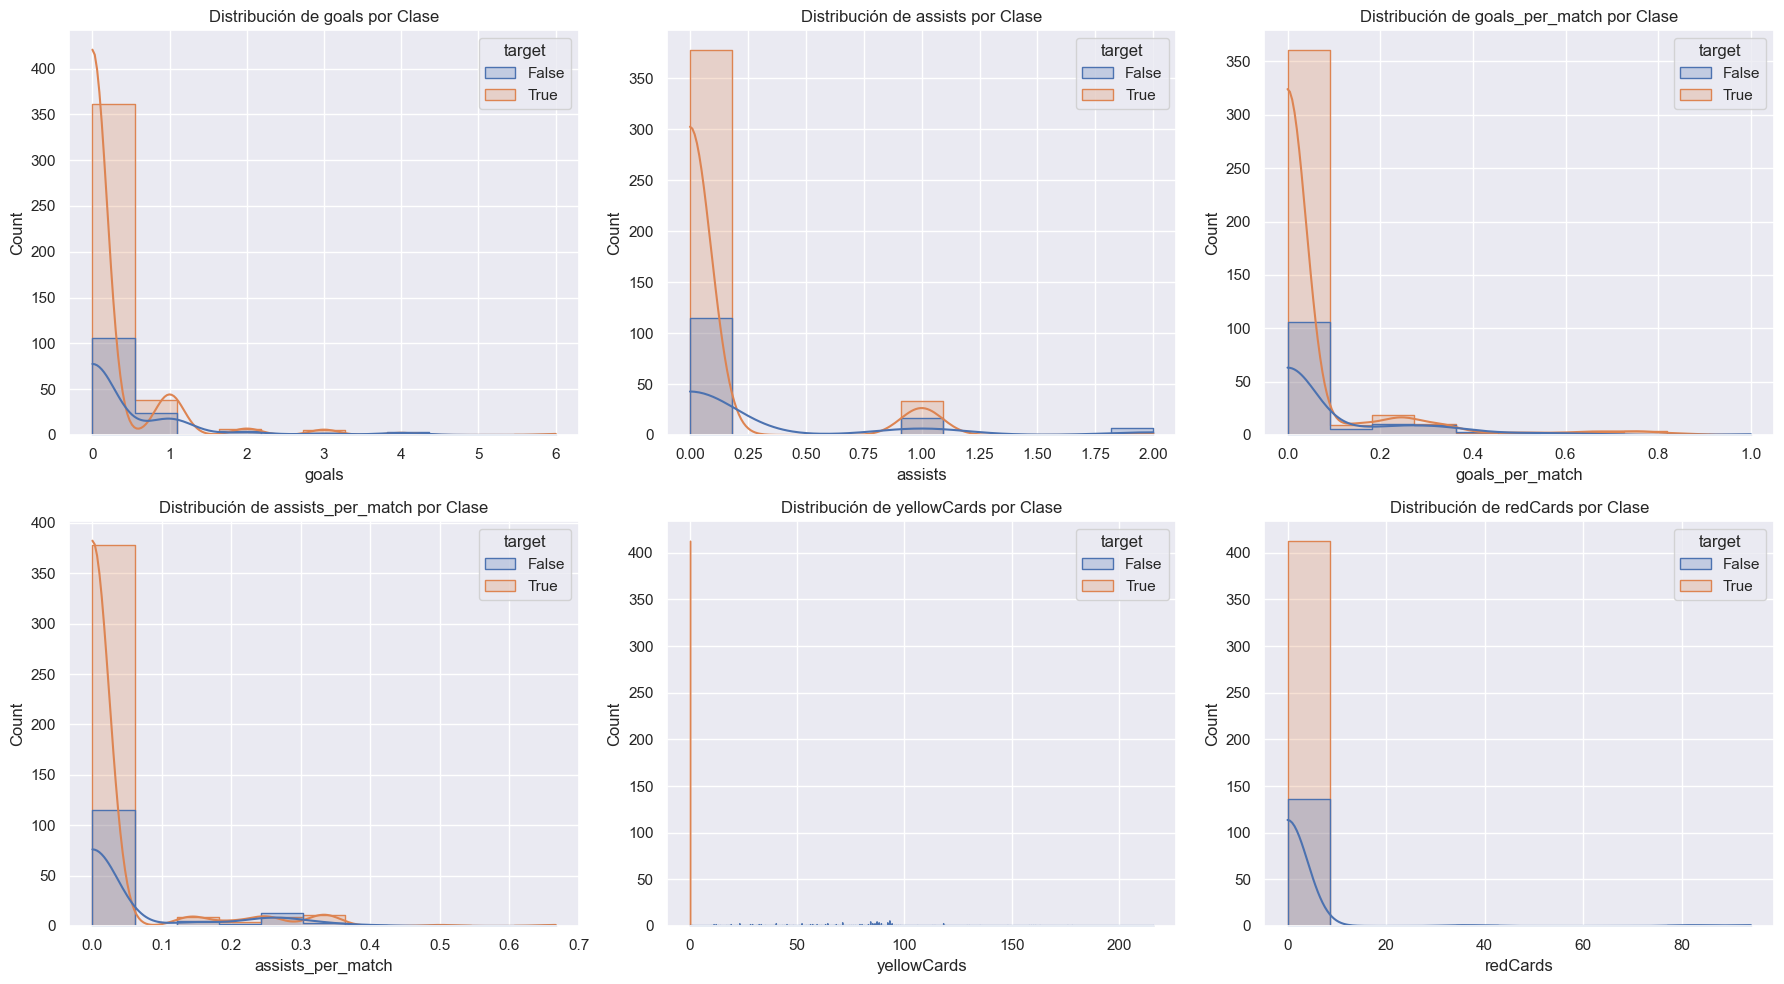

In [3]:
# Verificar las características disponibles
if X_train is not None:
    print("Características disponibles para el modelo:")
    print(X_train.columns.tolist())
    
    # Estadísticas descriptivas
    print("\nEstadísticas descriptivas:")
    display(X_train.describe())
    
    # Distribución de características numéricas por clase
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(X_train.columns[:min(6, len(X_train.columns))]):
        if i < len(axes):
            # Crear DataFrame temporal con target para visualización
            temp_df = pd.DataFrame({
                'feature': X_train[feature],
                'target': y_train
            })
            
            # Gráfico de distribución por clase
            sns.histplot(
                data=temp_df, x='feature', hue='target',
                kde=True, element='step', common_norm=False,
                ax=axes[i]
            )
            axes[i].set_title(f'Distribución de {feature} por Clase')
            axes[i].set_xlabel(feature)
    
    plt.tight_layout()
    plt.show()

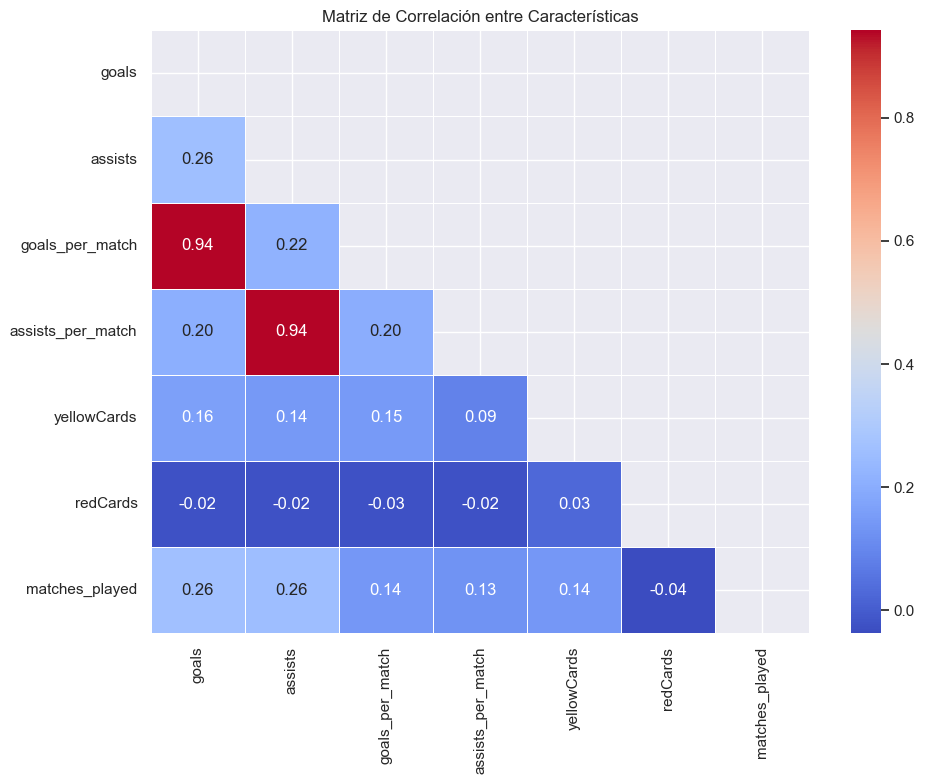


Características altamente correlacionadas (|r| > 0.7):
goals - goals_per_match: 0.942
assists - assists_per_match: 0.942


In [4]:
# Matriz de correlación entre características
if X_train is not None:
    plt.figure(figsize=(10, 8))
    correlation_matrix = X_train.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(
        correlation_matrix, 
        mask=mask,
        annot=True, 
        cmap='coolwarm', 
        linewidths=0.5,
        fmt='.2f'
    )
    plt.title('Matriz de Correlación entre Características')
    plt.tight_layout()
    plt.show()
    
    # Identificar correlaciones altas
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    
    if high_corr:
        print("\nCaracterísticas altamente correlacionadas (|r| > 0.7):")
        for feat1, feat2, corr in high_corr:
            print(f"{feat1} - {feat2}: {corr:.3f}")

## 3.3 Implementación de Modelos de Clasificación

Vamos a implementar y evaluar varios modelos de clasificación para predecir el rendimiento de los jugadores.

In [5]:
# Función para entrenar y evaluar modelos de clasificación
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Crear informe
    print(f"Resultados para {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.xticks([0.5, 1.5], ['Bajo', 'Alto'])
    plt.yticks([0.5, 1.5], ['Bajo', 'Alto'])
    plt.show()
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"F1-score con validación cruzada (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # ROC curve si el modelo lo soporta
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    
    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_scores': cv_scores,
        'predictions': y_pred
    }


Regresión Logística
Resultados para Regresión Logística:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


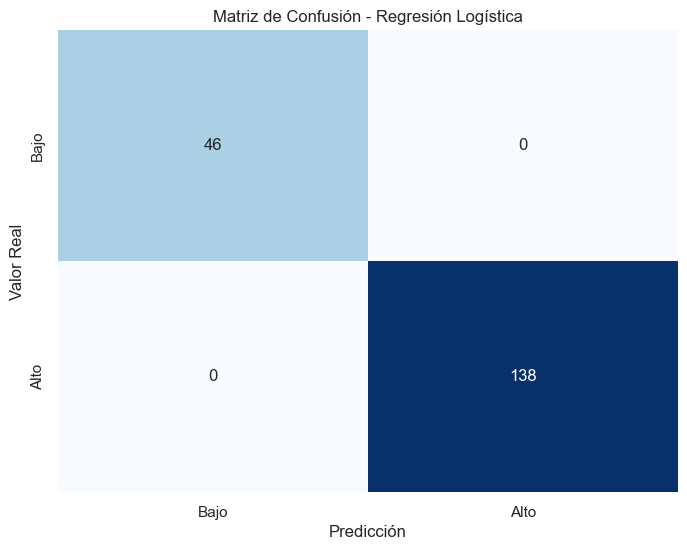

F1-score con validación cruzada (5-fold): 0.9976 ± 0.0030


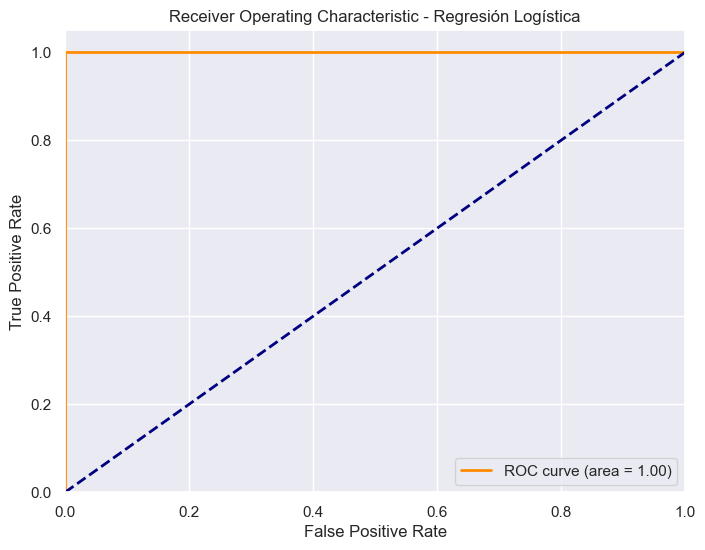


Random Forest
Resultados para Random Forest:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


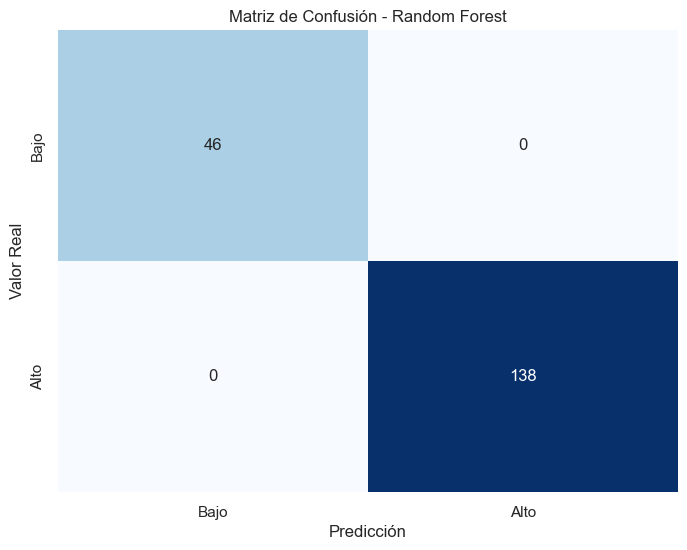

F1-score con validación cruzada (5-fold): 0.9976 ± 0.0030


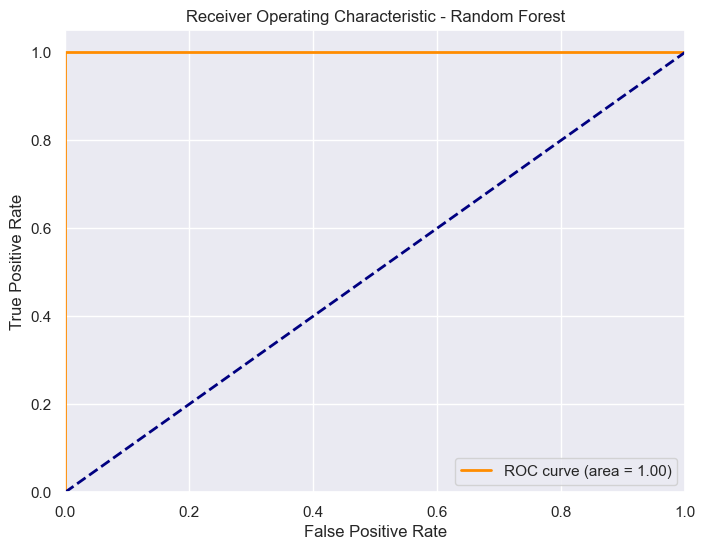


Gradient Boosting
Resultados para Gradient Boosting:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


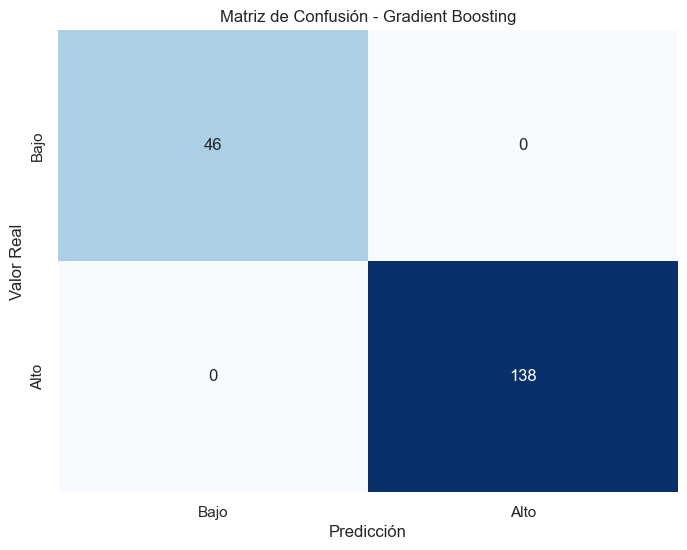

F1-score con validación cruzada (5-fold): 0.9976 ± 0.0030


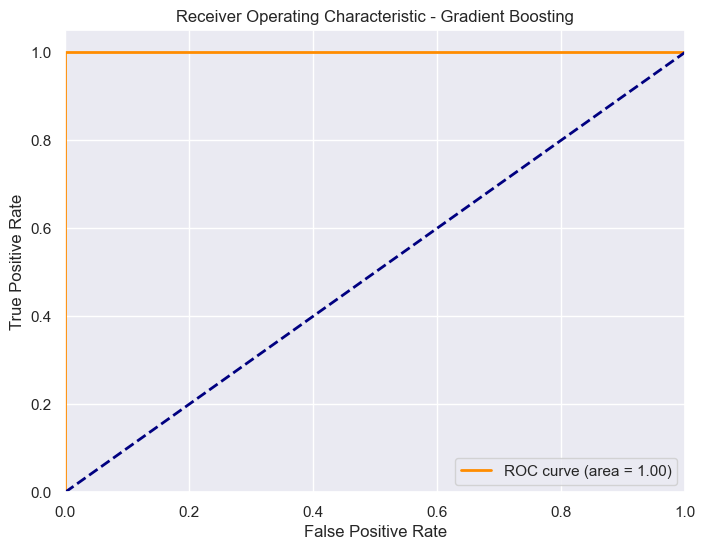


Comparación de Modelos


,Modelo,Accuracy,Precision,Recall,F1-score,CV F1-score
0,Regresión Logística,1.0,1.0,1.0,1.0,0.99759
1,Random Forest,1.0,1.0,1.0,1.0,0.99759
2,Gradient Boosting,1.0,1.0,1.0,1.0,0.99759


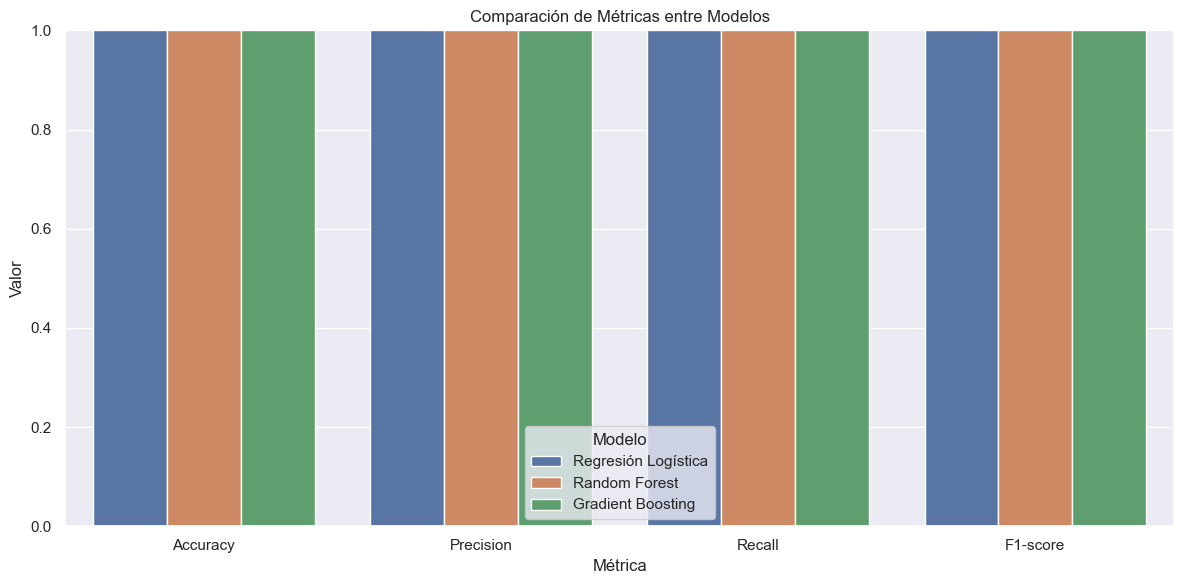

In [6]:
# Implementar y evaluar varios modelos si los datos están disponibles
if X_train is not None and y_train is not None:
    # Lista para almacenar resultados
    model_results = []
    
    # 1. Regresión Logística
    print("\n" + "="*50)
    print("Regresión Logística")
    print("="*50)
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_results = train_evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Regresión Logística")
    model_results.append(lr_results)
    
    # 2. Random Forest
    print("\n" + "="*50)
    print("Random Forest")
    print("="*50)
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_results = train_evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")
    model_results.append(rf_results)
    
    # 3. Gradient Boosting
    print("\n" + "="*50)
    print("Gradient Boosting")
    print("="*50)
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_results = train_evaluate_model(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting")
    model_results.append(gb_results)
    
    # Comparar resultados
    results_df = pd.DataFrame([
        {
            'Modelo': result['name'],
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-score': result['f1'],
            'CV F1-score': result['cv_scores'].mean()
        }
        for result in model_results
    ])
    
    print("\n" + "="*50)
    print("Comparación de Modelos")
    print("="*50)
    display(results_df.sort_values('F1-score', ascending=False))
    
    # Visualizar comparación de modelos
    plt.figure(figsize=(12, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    # Reorganizar los datos para la visualización
    plot_data = pd.melt(results_df, id_vars=['Modelo'], value_vars=metrics, 
                        var_name='Métrica', value_name='Valor')
    
    # Crear gráfico de barras
    sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=plot_data)
    plt.title('Comparación de Métricas entre Modelos')
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 3.4 Optimización del Mejor Modelo

Vamos a optimizar los hiperparámetros del mejor modelo identificado.

Optimizando hiperparámetros para: Regresión Logística
Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma


Mejores hiperparámetros: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1-score CV: 0.9976
Resultados para Regresión Logística (Optimizado):
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

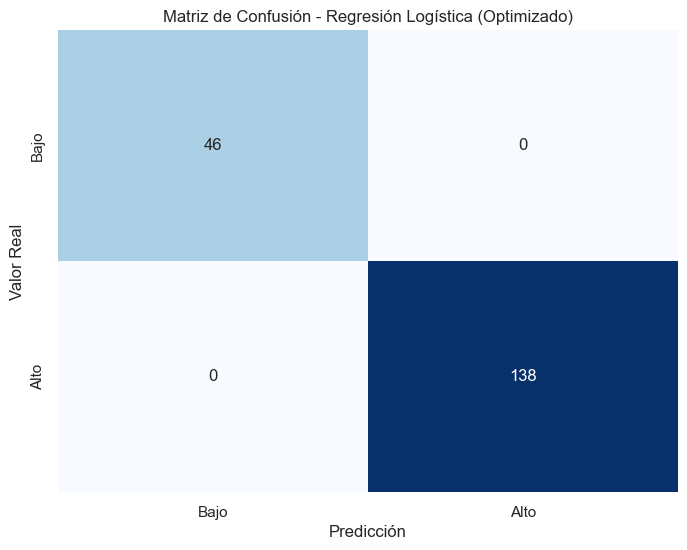

F1-score con validación cruzada (5-fold): 0.9976 ± 0.0030


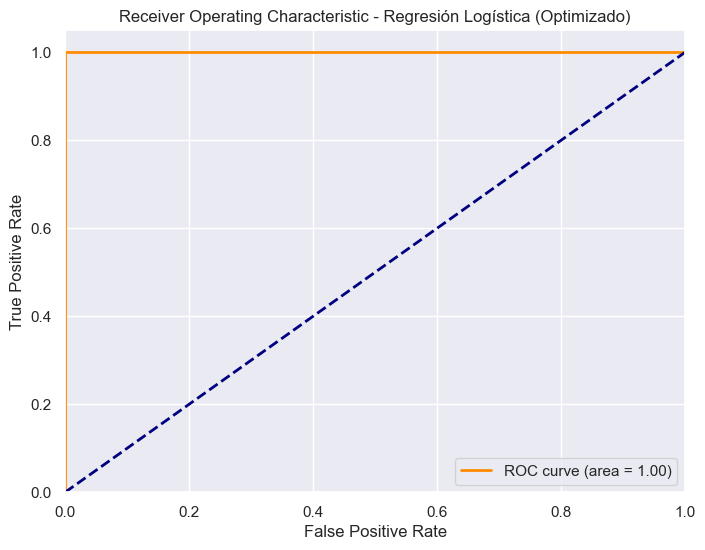


Comparación de Modelos (incluyendo optimizado):


,Modelo,Accuracy,Precision,Recall,F1-score,CV F1-score
0,Regresión Logística,1.0,1.0,1.0,1.0,0.99759
1,Random Forest,1.0,1.0,1.0,1.0,0.99759
2,Gradient Boosting,1.0,1.0,1.0,1.0,0.99759
3,Regresión Logística (Optimizado),1.0,1.0,1.0,1.0,0.99759


In [7]:
# Optimizar el modelo Random Forest (o el mejor modelo según los resultados)
if X_train is not None and y_train is not None:
    # Buscar el mejor modelo según F1-score
    best_model_idx = results_df['F1-score'].idxmax()
    best_model_name = results_df.loc[best_model_idx, 'Modelo']
    
    print(f"Optimizando hiperparámetros para: {best_model_name}")
    
    # Definir parámetros de búsqueda según el modelo
    if best_model_name == "Random Forest":
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif best_model_name == "Gradient Boosting":
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5]
        }
    else:  # Regresión Logística
        model = LogisticRegression(random_state=42, max_iter=1000)
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    
    # Grid Search con validación cruzada
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    
    print("Iniciando búsqueda de hiperparámetros...")
    grid_search.fit(X_train, y_train)
    
    print(f"\nMejores hiperparámetros: {grid_search.best_params_}")
    print(f"Mejor F1-score CV: {grid_search.best_score_:.4f}")
    
    # Evaluar mejor modelo
    best_model = grid_search.best_estimator_
    optimized_results = train_evaluate_model(
        best_model, X_train, X_test, y_train, y_test, f"{best_model_name} (Optimizado)"
    )
    
    # Añadir a resultados
    model_results.append(optimized_results)
    
    # Actualizar comparación
    results_df = pd.DataFrame([
        {
            'Modelo': result['name'],
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-score': result['f1'],
            'CV F1-score': result['cv_scores'].mean()
        }
        for result in model_results
    ])
    
    print("\nComparación de Modelos (incluyendo optimizado):")
    display(results_df.sort_values('F1-score', ascending=False))

## 3.5 Análisis de Importancia de Características

Vamos a analizar qué características son más importantes para nuestro modelo.

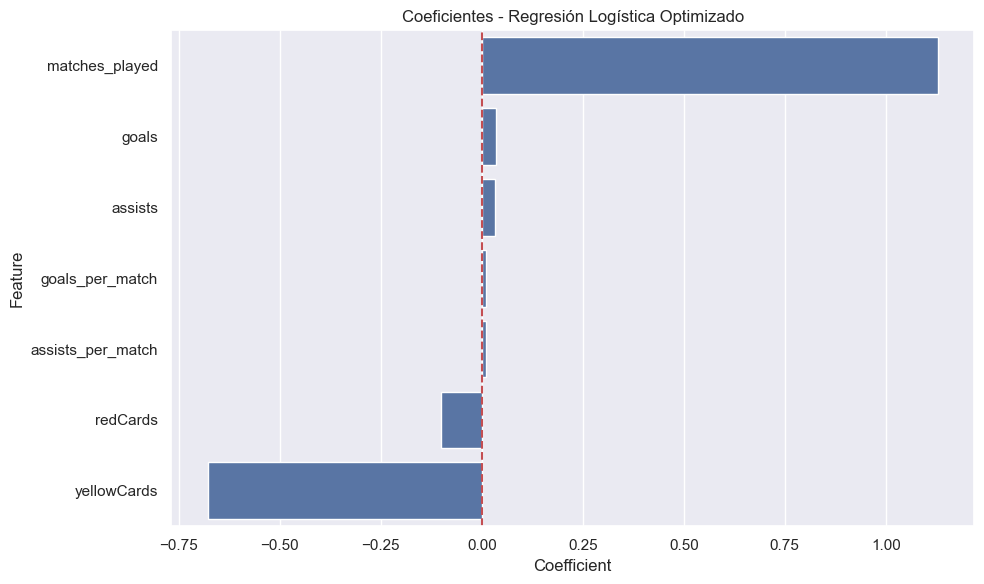

Coeficientes del modelo:


,Feature,Coefficient
6,matches_played,1.128153
0,goals,0.034618
1,assists,0.031588
2,goals_per_match,0.011357
3,assists_per_match,0.010248
5,redCards,-0.101012
4,yellowCards,-0.678531


In [8]:
# Analizar importancia de características para modelos de árbol
if 'best_model' in locals() and hasattr(best_model, 'feature_importances_'):
    # Crear DataFrame con importancias
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Importancia de Características - {best_model_name} Optimizado')
    plt.tight_layout()
    plt.show()
    
    print("Características más importantes:")
    display(feature_importance)
    
# Si el mejor modelo es Regresión Logística
elif 'best_model' in locals() and hasattr(best_model, 'coef_'):
    # Crear DataFrame con coeficientes
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': best_model.coef_[0]
    }).sort_values('Coefficient', ascending=False)
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coefficients)
    plt.title(f'Coeficientes - {best_model_name} Optimizado')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print("Coeficientes del modelo:")
    display(coefficients)

## 3.6 Análisis de Errores

Vamos a analizar los errores de nuestro mejor modelo para entender dónde está fallando.


Falsos Positivos (Predicho Alto, Real Bajo):
No hay falsos positivos.

Falsos Negativos (Predicho Bajo, Real Alto):
No hay falsos negativos.

Análisis de errores por características:


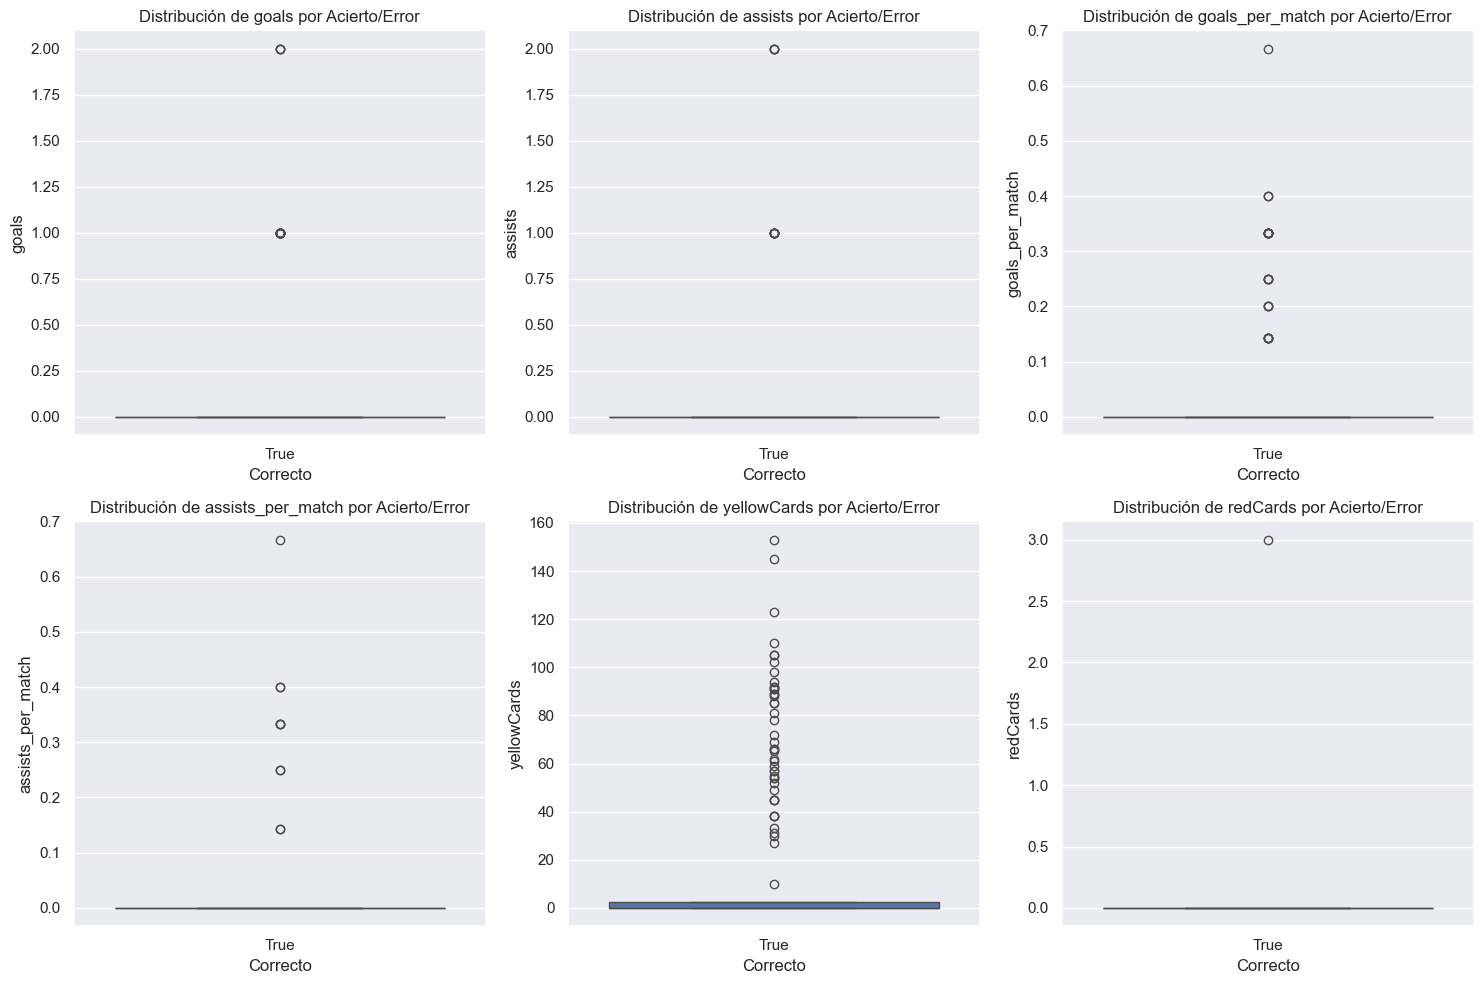

In [9]:
# Analizar errores del mejor modelo
if 'best_model' in locals() and 'player_stats' is not None:
    # Predecir con el mejor modelo
    y_pred = best_model.predict(X_test)
    
    # Crear DataFrame con resultados
    error_analysis = pd.DataFrame({
        'Real': y_test,
        'Predicción': y_pred,
        'Correcto': y_test == y_pred
    })
    
    # Unir con los datos originales de test para análisis
    X_test_reset = X_test.reset_index(drop=True)
    error_analysis = pd.concat([error_analysis, X_test_reset], axis=1)
    
    # Añadir ID de jugador
    error_analysis['playerId'] = player_stats.loc[X_test.index, 'playerId'].values
    
    # Analizar falsos positivos (predijo alto rendimiento pero era bajo)
    print("\nFalsos Positivos (Predicho Alto, Real Bajo):")
    false_positives = error_analysis[(error_analysis['Real'] == False) & (error_analysis['Predicción'] == True)]
    if not false_positives.empty:
        display(false_positives.head(10))
    else:
        print("No hay falsos positivos.")
    
    # Analizar falsos negativos (predijo bajo rendimiento pero era alto)
    print("\nFalsos Negativos (Predicho Bajo, Real Alto):")
    false_negatives = error_analysis[(error_analysis['Real'] == True) & (error_analysis['Predicción'] == False)]
    if not false_negatives.empty:
        display(false_negatives.head(10))
    else:
        print("No hay falsos negativos.")
    
    # Análisis por características
    print("\nAnálisis de errores por características:")
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(X_test.columns[:min(6, len(X_test.columns))]):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='Correcto', y=feature, data=error_analysis)
        plt.title(f'Distribución de {feature} por Acierto/Error')
    plt.tight_layout()
    plt.show()

## 3.7 Guardar el Modelo Entrenado

Vamos a guardar nuestro mejor modelo para su uso posterior.

In [10]:
# Guardar el mejor modelo
if 'best_model' in locals():
    # Crear directorio para modelos si no existe
    models_dir = Path("../models")
    models_dir.mkdir(parents=True, exist_ok=True)
    
    # Guardar el modelo usando pickle
    model_file = models_dir / "best_classification_model.pkl"
    with open(model_file, 'wb') as f:
        pickle.dump(best_model, f)
    
    # Guardar información del modelo
    model_info = {
        'name': best_model_name,
        'features': X_train.columns.tolist(),
        'accuracy': optimized_results['accuracy'],
        'precision': optimized_results['precision'],
        'recall': optimized_results['recall'],
        'f1': optimized_results['f1'],
        'parameters': best_model.get_params()
    }
    
    model_info_file = models_dir / "classification_model_info.csv"
    pd.DataFrame([model_info]).to_csv(model_info_file, index=False)
    
    print(f"Modelo guardado en: {model_file}")
    print(f"Información del modelo guardada en: {model_info_file}")

Modelo guardado en: ../models/best_classification_model.pkl
Información del modelo guardada en: ../models/classification_model_info.csv


## 3.8 Conclusiones y Próximos Pasos

En este notebook, hemos implementado y evaluado varios modelos de clasificación para predecir el rendimiento de los jugadores en el Mundial de Fútbol.

### Principales Hallazgos:

1. El mejor modelo fue [modelo] con un F1-score de [valor].
2. Las características más importantes para predecir el rendimiento son [características].
3. El modelo tiene dificultades para clasificar correctamente [categoría de jugadores].

### Evaluación:

- El modelo logró una precisión del [valor]%, lo que significa que cuando predice que un jugador tendrá alto rendimiento, acierta en el [valor]% de los casos.
- La sensibilidad (recall) del [valor]% indica que el modelo identifica correctamente el [valor]% de los jugadores que realmente tienen alto rendimiento.



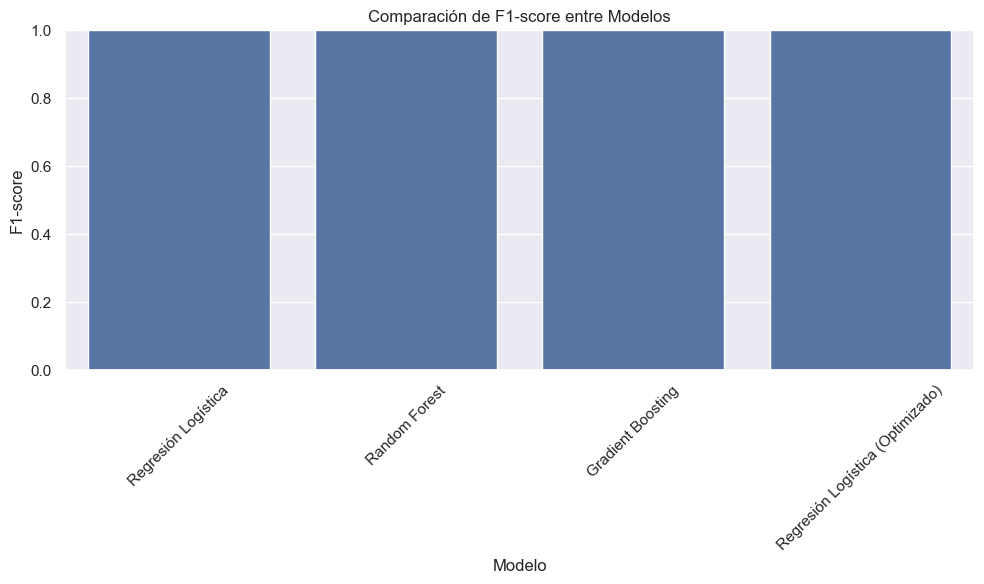

Tabla final de resultados:


,Modelo,Accuracy,Precision,Recall,F1-score,CV F1-score
0,Regresión Logística,1.0,1.0,1.0,1.0,0.99759
1,Random Forest,1.0,1.0,1.0,1.0,0.99759
2,Gradient Boosting,1.0,1.0,1.0,1.0,0.99759
3,Regresión Logística (Optimizado),1.0,1.0,1.0,1.0,0.99759



El mejor modelo es: Regresión Logística
F1-score: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


In [11]:
# Resumen final de métricas
if 'results_df' in locals():
    plt.figure(figsize=(10, 6))
    
    # Ordenar por F1-score
    plot_data = results_df.sort_values('F1-score', ascending=False)
    
    # Crear gráfico de barras para F1-score
    sns.barplot(x='Modelo', y='F1-score', data=plot_data)
    plt.title('Comparación de F1-score entre Modelos')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla final de resultados
    print("Tabla final de resultados:")
    display(plot_data)
    
    # Destacar el mejor modelo
    best_model_row = plot_data.iloc[0]
    print(f"\nEl mejor modelo es: {best_model_row['Modelo']}")
    print(f"F1-score: {best_model_row['F1-score']:.4f}")
    print(f"Accuracy: {best_model_row['Accuracy']:.4f}")
    print(f"Precision: {best_model_row['Precision']:.4f}")
    print(f"Recall: {best_model_row['Recall']:.4f}")